# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import os
import glob
import geometric_sampling as gs
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri, default_converter
from rpy2.robjects.conversion import localconverter
from package_sampling.utils import inclusion_probabilities

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R

library(WaveSampling)
library(sampling)
library(BalancedSampling)


Loading required package: Matrix


# Moran and Local Balance Score

In [5]:
def score_all_samples_moran_lb(coords, probs, sample_indices_list):
    """
    coords          : an (N×2)-array of spatial coordinates
    probs           : length-N array of inclusion probabilities
    sample_indices_list : list of length-n integer numpy arrays (0-based indices)

    Returns an (S×2) numpy array of [IB, SBLB] for each of the S samples.
    """

    # Convert Python list of numpy arrays into an R list of integer vectors
    #   * add +1 because R is 1-based
    r_sample_list = ro.ListVector({
        str(i+1): ro.IntVector(sample_idx.astype(int) + 1)
        for i, sample_idx in enumerate(sample_indices_list)
    })

    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['coords'] = coords
        ro.globalenv['probs'] = probs
        # Precompute W once
        ro.r("""
            W0 <- wpik(coords, probs)
            W <- W0 - diag(diag(W0))
            diag(W) <- 0
        """)
        ro.globalenv['samples'] = r_sample_list

        # Define an R function that loops over all samples
        ro.r("""
            score_samples <- function(W, probs, coords, samples_list) {
              S <- length(samples_list)
              IBs   <- numeric(S)
              SBLBs <- numeric(S)

              for (i in seq_len(S)) {
                samp_idx <- samples_list[[i]]
                mask <- integer(length(probs))
                mask[samp_idx] <- 1

                IBs[i]   <- tryCatch(IB(W, mask),        error = function(e) Inf)
                SBLBs[i] <- tryCatch(sblb(probs, coords, samp_idx), error = function(e) Inf)
              }
              # return as a 2-column matrix
              cbind(IB = IBs, SBLB = SBLBs)
            }
        """)

        # Call it once
        result = ro.r("score_samples(W, probs, coords, samples)")
        # result comes back as an R matrix  S×2

    # Turn it into an (S×2) numpy array
    with localconverter(default_converter + numpy2ri.converter):
        np_result = np.array(result)
    return np_result[:, 0], np_result[:, 1]


# Loading Population

In [6]:
DATA_DIR = "../data_samples/coords_probs"
csv_paths = glob.glob(os.path.join(DATA_DIR, "*.csv"))

coords_dict = {}
probs_dict = {}

for fp in csv_paths:
    if 'swiss' not in fp:
        name = os.path.splitext(os.path.basename(fp))[0]
        data = np.loadtxt(fp, delimiter=",", skiprows=1)
        coords = data[:, :2]
        probs  = data[:, -1]

        coord_name, prob_name = name.split("_")
        coord_name = 'cluster' if coord_name == 'clust' else coord_name
        prob_name = 'equal' if prob_name == 'eq' else 'unequal'

        coords_dict[coord_name] = coords
        probs_dict[coord_name] = probs_dict.get(coord_name, {})
        probs_dict[coord_name][prob_name] = probs

print(coords_dict.keys())
print(probs_dict.keys())
print(probs_dict['random'].keys())

dict_keys(['random', 'cluster', 'meuse', 'grid'])
dict_keys(['random', 'cluster', 'meuse', 'grid'])
dict_keys(['equal', 'unequal'])


# Evaluation Function

In [7]:
def top_n_records(df: pd.DataFrame,
                  name_cols: list,
                  sort_col: str = 'exp_moran',
                  k: int = 10,
                  smallest: bool = True) -> pd.DataFrame:

    df_copy = df.copy()

    df_copy['name'] = df_copy[name_cols].astype(str).agg(' - '.join, axis=1)

    if smallest:
        return df_copy.nsmallest(k, sort_col)[['name', sort_col]].reset_index(drop=True)
    return df_copy.nlargest(k, sort_col)[['name', sort_col]].reset_index(drop=True)

In [45]:
def evaluate(
        coords_dict,
        probs_dict,
        n_values=[4, 8, 16],
        zone_list=[(1, 1), (2, 2), (3, 3)],
        sort_method_list=['lexico', 'random', 'angle_0', 'distance_0', 'projection', "center", "spiral", "max"],
        zonal_sort_list=['lexico', 'random', 'angle_0', 'distance_0', 'projection', "center", "spiral", "max"],
        tolerance=5,
        split_size=1e-3,
):
    records = []

    # pre‐compute all combinations
    combos = list(itertools.product(
        n_values,
        zone_list,
        sort_method_list,
        zonal_sort_list
    ))

    for n, zones, sort_method, zonal_sort in tqdm(
        combos,
        desc="Total combos",
        unit="combo"
    ):

        for coord_name in probs_dict.keys():
            for prob_name in probs_dict[coord_name].keys():

                coords = coords_dict[coord_name]
                probs = probs_dict[coord_name][prob_name]

                kss = gs.sampling.KMeansSpatialSamplingSimple(
                    coords, probs,
                    n=n,
                    n_zones=zones,
                    tolerance=tolerance,
                    split_size=split_size,
                    sort_method = sort_method,
                    zonal_sort = zonal_sort,
                    zone_mode='cluster'
                )

                density_expected = np.round(kss.expected_score(), 4)
                density_val = np.round(kss.var_score(), 4)

                moran_scores, lb_scores = score_all_samples_moran_lb(coords, probs, kss.all_samples)

                moran_expected = np.round(kss.expected_score(moran_scores), 4)
                moran_val = np.round(kss.var_score(moran_scores), 4)

                lb_expected = np.round(kss.expected_score(lb_scores), 4)
                lb_val = np.round(kss.var_score(lb_scores), 4)

                records.append({
                    # 'n': n,
                    # 'zones': f"{zones[0]}×{zones[1]}",
                    'zones': zones,
                    'bar_sort': sort_method,
                    'zonal_sort': zonal_sort if zonal_sort else 'None',
                    'coord': coord_name,
                    'prob': prob_name,
                    'exp_density': density_expected,
                    'exp_moran': moran_expected,
                    'exp_lb': lb_expected,
                    'var_density': density_val,
                    'var_moran': moran_val,
                    'var_lb': lb_val,
                })

    return pd.DataFrame.from_records(records)


In [48]:
df = evaluate(
    coords_dict,
    probs_dict,
    n_values=[4],
    # zone_list=[(1, 1), (2, 2), (3, 3)],
    zone_list=[2, 3, 4],
    sort_method_list=['distance_0', 'projection'],
    zonal_sort_list=[None, 'distance_0', 'projection'],
    tolerance=5,
    split_size=1e-3,
)

Total combos: 100%|██████████| 18/18 [04:34<00:00, 15.26s/combo]


In [49]:
summary = df.pivot_table(
    columns=['zones', 'zonal_sort', 'bar_sort'],
    # values=['exp_density', 'exp_moran', 'exp_lb', 'var_density', 'var_moran', 'var_lb'],
    values=['exp_moran',],
    index=['coord', 'prob'],
    aggfunc='first'
)

summary

exp_moran                                              \
zones                    2                                               
zonal_sort            None            distance_0            projection   
bar_sort        distance_0 projection distance_0 projection distance_0   
coord   prob                                                             
cluster equal      -0.1253    -0.1276    -0.1985    -0.2043    -0.1915   
        unequal    -0.0786    -0.1228    -0.1248    -0.1248    -0.1248   
grid    equal      -0.1116    -0.2019    -0.1781    -0.1758    -0.1758   
        unequal    -0.1174    -0.0574    -0.1174    -0.1174    -0.1174   
meuse   equal      -0.2683    -0.2547    -0.2745    -0.2745    -0.2745   
        unequal    -0.1968    -0.1676    -0.2193    -0.2183    -0.2193   
random  equal      -0.1618    -0.1318    -0.1603    -0.1618    -0.1600   
        unequal    -0.0869    -0.1104    -0.1336    -0.1341    -0.1336   

                                                                        \
zones                               3                                    
zonal_sort                       None            distance_0              
bar_sort        projection distance_0 projection distance_0 projection   
coord   prob                                                             
cluster equal      -0.1985    -0.2449    -0.1455    -0.2392    -0.2384   
        unequal    -0.1248    -0.1149    -0.1299    -0.1058    -0.1294   
grid    equal      -0.1781    -0.1489    -0.1537    -0.1900    -0.1576   
        unequal    -0.1174    -0.0971    -0.0973    -0.1215    -0.1215   
meuse   equal      -0.2745    -0.2612    -0.1856    -0.3335    -0.3335   
        unequal    -0.2183    -0.1839    -0.1416    -0.2228    -0.2228   
random  equal      -0.1603    -0.1551    -0.1615    -0.1573    -0.1573   
        unequal    -0.1336    -0.0977    -0.1498    -0.1219    -0.1274   

                                                                        \
zones                                          4                         
zonal_sort      projection                  None            distance_0   
bar_sort        distance_0 projection distance_0 projection distance_0   
coord   prob                                                             
cluster equal      -0.2385    -0.2485    -0.3012    -0.2648    -0.3162   
        unequal    -0.1068    -0.1083    -0.1405    -0.0956    -0.1454   
grid    equal      -0.1708    -0.1478    -0.1527    -0.1396    -0.2041   
        unequal    -0.1229    -0.1197    -0.0938    -0.1060    -0.1224   
meuse   equal      -0.3335    -0.3335    -0.2753    -0.1998    -0.2930   
        unequal    -0.2228    -0.2228    -0.2206    -0.1668    -0.2395   
random  equal      -0.1571    -0.1568    -0.1502    -0.1106    -0.1756   
        unequal    -0.1245    -0.1245    -0.1096    -0.0926    -0.1158   

                                                  
zones                                             
zonal_sort                 projection             
bar_sort        projection distance_0 projection  
coord   prob                                      
cluster equal      -0.3118    -0.3211    -0.3240  
        unequal    -0.1450    -0.1302    -0.1267  
grid    equal      -0.1683    -0.1817    -0.1761  
        unequal    -0.1186    -0.1085    -0.1220  
meuse   equal      -0.2926    -0.3298    -0.3271  
        unequal    -0.2307    -0.2223    -0.2203  
random  equal      -0.1734    -0.1756    -0.1756  
        unequal    -0.1158    -0.1112    -0.1116

# Meuse

In [67]:
coords = coords_dict['meuse']
probs = probs_dict['meuse']['unequal']*()
n=30
zones = (1, 1)
zone_mode = 'sweep'
tolerance = 5
split_size = 1e-3
sort_method = 'lexico'
zonal_sort = None

kss = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probs,
            n=n,
            n_zones=zones if zone_mode == 'sweep' else zones[0]+1,
            tolerance=tolerance,
            split_size=split_size,
            zone_mode=zone_mode,
            sort_method=sort_method,
            zonal_sort=zonal_sort
        )

samples = kss.sample(1000)

# kss.popu.plot_with_samples(samples)

In [78]:
inclusion_probabilities(probs, n=30)

np.float64(30.0)

In [72]:
moran_scores, lb_scores = score_all_samples_moran_lb(coords, probs, samples)
np.argmax(moran_scores), moran_scores[np.argmax(moran_scores)]

(np.int64(4), np.float64(-0.012958958921919719))

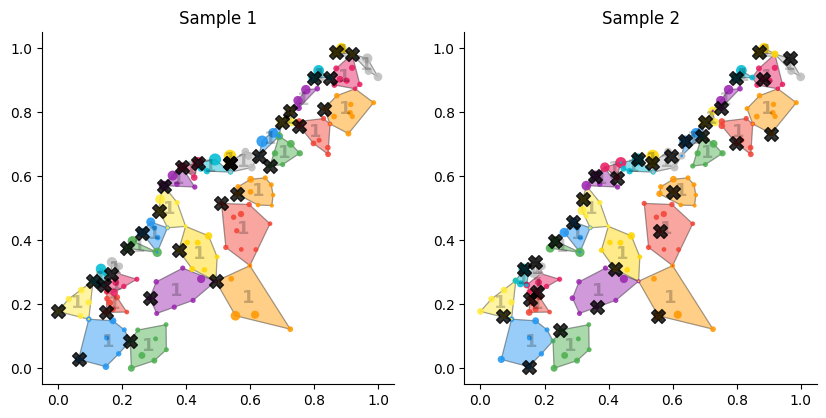

In [75]:
kss.popu.plot_with_samples(samples[[4, 5]], 2)

In [87]:
def evaluate_meuse(
        coords_dict,
        probs_dict,
        n_values=[4],
        zone_list=[(1, 1), (2, 2), (3, 3)],
        sort_method_list=['lexico', 'random', 'angle_0', 'distance_0', 'projection', "center", "spiral", "max"],
        zonal_sort_list=['lexico', 'random', 'angle_0', 'distance_0', 'projection', "center", "spiral", "max"],
        zone_mode_list=['sweep' 'cluster'],
        tolerance=5,
        split_size=1e-3,
):
    records = []

    # pre‐compute all combinations
    combos = list(itertools.product(
        n_values,
        zone_list,
        zone_mode_list,
        zonal_sort_list,
        sort_method_list
    ))
    coords = coords_dict['meuse']
    probs = probs_dict['meuse']['equal']

    for n, zones, zone_mode, zonal_sort, sort_method in tqdm(
        combos,
        desc="Total combos",
        unit="combo"
    ):

        # print(n, zones, zone_mode, zonal_sort, sort_method)

        modified_probs = inclusion_probabilities(probs, n=n)
        kss = gs.sampling.KMeansSpatialSamplingSimple(
            coords, modified_probs,
            n=n,
            n_zones=zones if zone_mode == 'sweep' else zones[0]+1,
            tolerance=tolerance,
            split_size=split_size,
            zone_mode=zone_mode,
            sort_method=sort_method,
            zonal_sort=zonal_sort
        )

        density_expected = np.round(kss.expected_score(), 4)
        density_val = np.round(kss.var_score(), 4)

        moran_scores, lb_scores = score_all_samples_moran_lb(coords, modified_probs, kss.all_samples)

        moran_expected = np.round(kss.expected_score(moran_scores), 4)
        moran_val = np.round(kss.var_score(moran_scores), 4)

        lb_expected = np.round(kss.expected_score(lb_scores), 4)
        lb_val = np.round(kss.var_score(lb_scores), 4)

        records.append({
            'n': n,
            'zones': zones if zone_mode == 'cluster' else f"{zones[0]}×{zones[1]}",
            'zone_mode': zone_mode,
            'bar_sort': sort_method,
            'zonal_sort': zonal_sort if zonal_sort else 'None',
            'exp_density': density_expected,
            'exp_moran': moran_expected,
            'exp_lb': lb_expected,
            'var_density': density_val,
            'var_moran': moran_val,
            'var_lb': lb_val,
        })

    return pd.DataFrame.from_records(records)


In [88]:
df = evaluate_meuse(
    coords_dict,
    probs_dict,
    n_values=[15, 30],
    zone_list=[(1, 1)],
    # zone_list=[2, 3, 4, 5],
    sort_method_list=['lexico', 'random', 'distance_0', 'projection', "max"],
    # zonal_sort_list=[None,'lexico', 'random', 'distance_0', 'projection', "max"],
    zonal_sort_list=[None],
    zone_mode_list=['sweep'],
    tolerance=5,
    split_size=1e-3,
)

Total combos:   0%|          | 0/10 [00:00<?, ?combo/s]

1 75 0.0133


Total combos:  20%|██        | 2/10 [00:14<00:58,  7.27s/combo]

6 77 0.0779


Total combos:  30%|███       | 3/10 [00:21<00:49,  7.13s/combo]

0 90 0.0


Total combos:  40%|████      | 4/10 [00:29<00:43,  7.25s/combo]

0 105 0.0


Total combos:  50%|█████     | 5/10 [00:35<00:34,  6.93s/combo]

4 97 0.0412


Total combos:  60%|██████    | 6/10 [01:10<01:06, 16.56s/combo]

3 78 0.0385


Total combos:  70%|███████   | 7/10 [01:44<01:06, 22.29s/combo]

12 81 0.1481


Total combos:  80%|████████  | 8/10 [02:29<00:58, 29.26s/combo]

17 82 0.2073


Total combos:  90%|█████████ | 9/10 [03:06<00:31, 31.89s/combo]

0 94 0.0


Total combos: 100%|██████████| 10/10 [03:42<00:00, 22.28s/combo]

8 80 0.1


In [89]:
summary = df.pivot_table(
    values=['exp_density', 'exp_moran'],
    columns=['n', 'zones'],
    index=['zonal_sort', 'bar_sort'],
    aggfunc='first'
)

summary

exp_density         exp_moran        
n                              15      30        15      30
zones                         1×1     1×1       1×1     1×1
zonal_sort bar_sort                                        
None       distance_0      0.0346  0.0161   -0.3892 -0.4989
           lexico          0.0252  0.0104   -0.3328 -0.4702
           max             0.0267  0.0068   -0.3469 -0.4280
           projection      0.0255  0.0174   -0.3948 -0.4678
           random          0.0530  0.0237   -0.2935 -0.3800

In [36]:
top_n_records(df, ['zonal_sort', 'bar_sort', 'zones'], k=10)

,name,exp_moran
0,distance_0 - lexico - 3,-0.3426
1,random - lexico - 5,-0.3400
2,projection - distance_0 - 4,-0.3355
3,distance_0 - random - 3,-0.3335
4,distance_0 - distance_0 - 3,-0.3335
5,distance_0 - projection - 3,-0.3335
6,distance_0 - max - 3,-0.3335
7,projection - lexico - 3,-0.3335
8,projection - random - 3,-0.3335
9,projection - distance_0 - 3,-0.3335


In [72]:
df = evaluate_meuse(
    coords_dict,
    probs_dict,
    n_values=[4],
    zone_list=[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10)],
    sort_method_list=['random'],
    tolerance=5,
    split_size=1e-3,
)

Total combos: 100%|██████████| 10/10 [00:04<00:00,  2.34combo/s]


In [34]:
summary = df.pivot_table(
    columns=['sort'],
    values=['exp_density', 'exp_moran', 'var_density', 'var_moran'],
    index=['zones'],
    aggfunc='first'
)

summary

KeyError: 'sort'